<a href="https://colab.research.google.com/github/SharvariAB/Edge-AI-based-Wafer-Defect-Detection/blob/main/wafer-defect-edge-ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os

zip_path = "/content/WM811k_Dataset.zip"
extract_path = "/content/raw_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted folders:", os.listdir(extract_path))


Extracted folders: ['WM811k_Dataset']


In [2]:
import os, shutil, random
from sklearn.model_selection import train_test_split

SOURCE = "/content/raw_data/WM811k_Dataset"
TARGET = "/content/dataset"

CLASS_MAP = {
    "Clean": "none",
    "Other": "random",
    "Shorts": "Local",
    "Opens": "Donut",
    "Bridges": "Edge Ring",
    "Cracks": "Scratch",
    "Malformed_Vias": "Center",
    "LER": "Edge Local"
}

for split in ["train", "val", "test"]:
    for cls in CLASS_MAP.keys():
        os.makedirs(f"{TARGET}/{split}/{cls}", exist_ok=True)

for cls, src in CLASS_MAP.items():
    images = os.listdir(f"{SOURCE}/{src}")
    images = random.sample(images, min(len(images), 150))  # limit for speed

    train, temp = train_test_split(images, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    for img in train:
        shutil.copy(f"{SOURCE}/{src}/{img}", f"{TARGET}/train/{cls}/{img}")
    for img in val:
        shutil.copy(f"{SOURCE}/{src}/{img}", f"{TARGET}/val/{cls}/{img}")
    for img in test:
        shutil.copy(f"{SOURCE}/{src}/{img}", f"{TARGET}/test/{cls}/{img}")

print("Dataset ready ✔")


Dataset ready ✔


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v3_small
from torch.utils.data import DataLoader
from collections import Counter


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


In [14]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((96, 96)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder("/content/dataset/train", transform)
val_ds   = datasets.ImageFolder("/content/dataset/val", transform)
test_ds  = datasets.ImageFolder("/content/dataset/test", transform)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=32)
test_dl  = DataLoader(test_ds, batch_size=32)

print("Classes:", train_ds.classes)


Classes: ['Bridges', 'Clean', 'Cracks', 'LER', 'Malformed_Vias', 'Opens', 'Other', 'Shorts']


In [15]:
labels = [label for _, label in train_ds.samples]
class_count = Counter(labels)

weights = [1.0 / class_count[i] for i in range(len(class_count))]
class_weights = torch.tensor(weights).to(device)

print("Class weights:", class_weights)


Class weights: tensor([0.0141, 0.0143, 0.0143, 0.0139, 0.0143, 0.0141, 0.0143, 0.0143])


In [16]:
from torchvision.models import mobilenet_v3_small

model = mobilenet_v3_small(weights="IMAGENET1K_V1")

# ONLY change classifier
model.classifier[3] = nn.Linear(1024, 8)

model = model.to(device)


In [ ]:
model = mobilenet_v3_small(weights="IMAGENET1K_V1")

# Change first layer to accept 1-channel (grayscale)
model.features[0][0] = nn.Conv2d(
    1, 16, kernel_size=3, stride=2, padding=1, bias=False
)

# Change classifier to 8 classes
model.classifier[3] = nn.Linear(1024, 8)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 54.8MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0005)


In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss/len(train_dl):.4f}")


Epoch 1/10 - Loss: 2.1811
Epoch 2/10 - Loss: 2.1653
Epoch 3/10 - Loss: 2.1903
Epoch 4/10 - Loss: 2.2072
Epoch 5/10 - Loss: 2.1574
Epoch 6/10 - Loss: 2.1862
Epoch 7/10 - Loss: 2.1765
Epoch 8/10 - Loss: 2.1978
Epoch 9/10 - Loss: 2.1753
Epoch 10/10 - Loss: 2.1972


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        preds = torch.argmax(model(images), dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted")
rec  = recall_score(y_true, y_pred, average="weighted")

print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")


Accuracy  : 0.0732
Precision : 0.0476
Recall    : 0.0732


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
class EdgeCNN(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x.view(x.size(0), -1))


In [18]:
model = EdgeCNN(num_classes=8).to(device)


In [19]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [20]:
EPOCHS = 15

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss/len(train_dl):.4f}")


Epoch 1/15 - Loss: 1.9167
Epoch 2/15 - Loss: 1.6754
Epoch 3/15 - Loss: 1.5910
Epoch 4/15 - Loss: 1.5296
Epoch 5/15 - Loss: 1.4561
Epoch 6/15 - Loss: 1.4417
Epoch 7/15 - Loss: 1.4412
Epoch 8/15 - Loss: 1.3663
Epoch 9/15 - Loss: 1.3020
Epoch 10/15 - Loss: 1.2933
Epoch 11/15 - Loss: 1.2508
Epoch 12/15 - Loss: 1.2389
Epoch 13/15 - Loss: 1.1929
Epoch 14/15 - Loss: 1.1985
Epoch 15/15 - Loss: 1.2173


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        preds = torch.argmax(model(images), dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted")
rec  = recall_score(y_true, y_pred, average="weighted")

print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")


Accuracy  : 0.4146
Precision : 0.4099
Recall    : 0.4146


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dl:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


In [23]:
cm = confusion_matrix(all_labels, all_preds)
print(cm)


[[ 8  0  1  5  0  0  1  1]
 [ 0  0 13  0  0  0  0  2]
 [ 0  0  6  1  0  0  1  7]
 [ 0  0  2  2  0  0  3  9]
 [ 0  0  7  2  0  0  1  5]
 [ 0  0  1  0  0  7  2  6]
 [ 0  0  0  0  0  1 14  0]
 [ 0  0  1  0  0  0  0 14]]


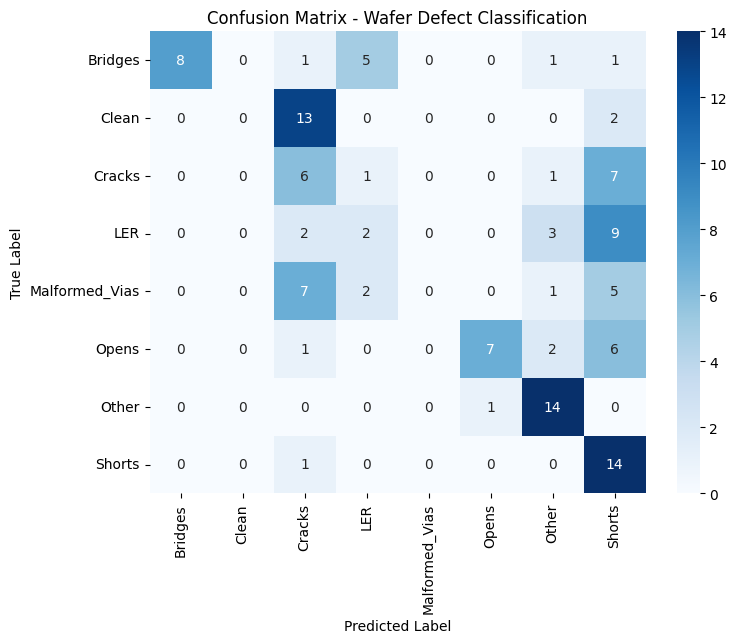

In [24]:
class_names = test_ds.classes  # automatically picks folder names

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Wafer Defect Classification")
plt.show()
